# Seismic Facies Classification using a unsupervised machine learning approach

For this project, I'm going to use self organized maps to classify seismic facies.

The data that I'm going to use is from a public repositoy with seismic and well information form the F3 block, in the North Sea Offshore.

The repository is located in this link

https://terranubis.com/datainfo/F3-Demo-2020

In addition to this work there is a GitHub repository with the code and the input data for this notebook.

https://github.com/edmon2017/seismicfacies

## Problem description
Seismic data is an important tool for oil and gas exploration and production, one of the benefits of this tool is that allows to interpret the behavior of the rocks in subsurface.

However because this process is an indirect interpretation, it has a lot of uncertainties.

In this project, I try to estimate facies from seismic data, which basically are rock with similar properties.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from sklearn.metrics import accuracy_score, confusion_matrix
from scipy.optimize import linear_sum_assignment
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.model_selection import ParameterGrid
from minisom import MiniSom
import segyio
import seaborn as sns

The first step is load the data. In this project I'm going to use some seismic attributes that are going to be the predictors for the seismic facies.

I'm going to use the library segyio, and geneerate tow functions to load and display the data

In [3]:
def plotseismic(array_sismico,name):
    #array_sismico = data
    plt.figure(figsize=(10, 4))
    plt.imshow(array_sismico.T, aspect='auto', cmap='gray_r')#, vmin=-np.percentile(np.abs(array_sismico), 95), vmax=np.percentile(np.abs(array_sismico), 95))
    plt.colorbar(label='Amplitud')
    plt.xlabel('Trace')
    plt.ylabel('Time')
    plt.title(f'{name}')
    plt.show()

def seismic2df(filename,line,name,topwindow):
    with segyio.open(filename) as segyfile:
        amplitude = segyfile.iline[segyfile.ilines[line]]
        xlines = segyfile.xlines[:]
        #samples = segyfile.samples[:]
        amplitude = amplitude[:,topwindow:]
        samples = segyfile.samples[topwindow:]
    plotseismic(amplitude,name)
    df = pd.DataFrame(data=amplitude.T, index=samples, columns=xlines)
    stacked = df.stack()
    stacked.name = name
    df_flat = stacked.to_frame()
    return df_flat

## Exploratory Data Analysis and Data Conditioning
The data that I'm going to use is composed by the original seismic amplitude and four additional attibutes. I'm going to load a line for each of this volumes, for a visual inpection of the data

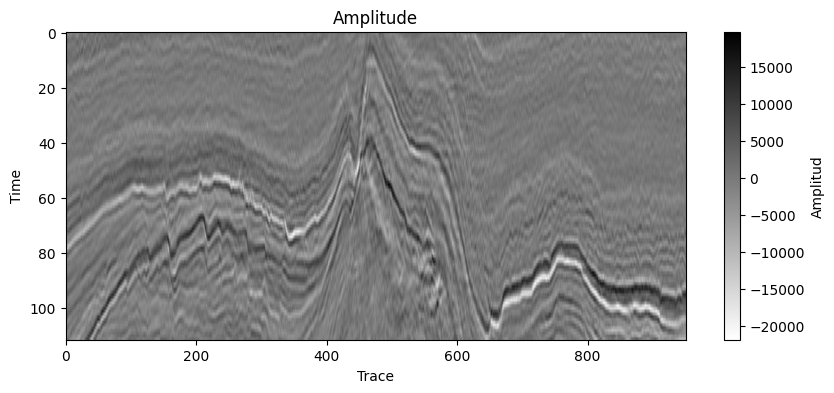

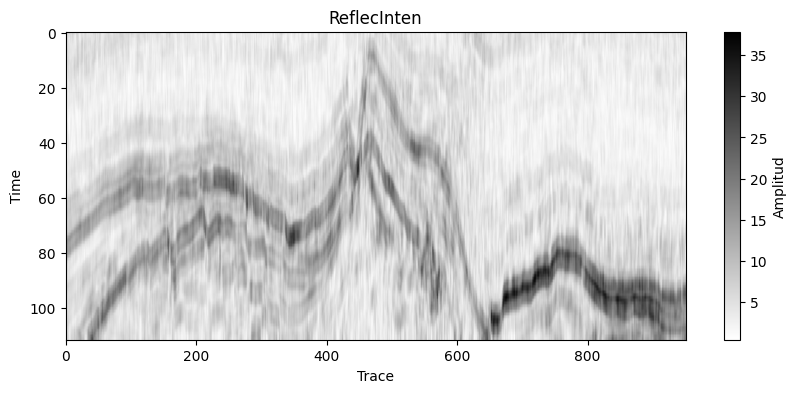

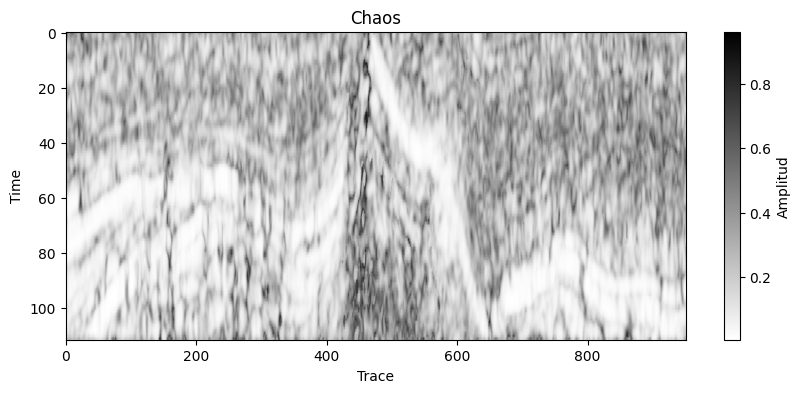

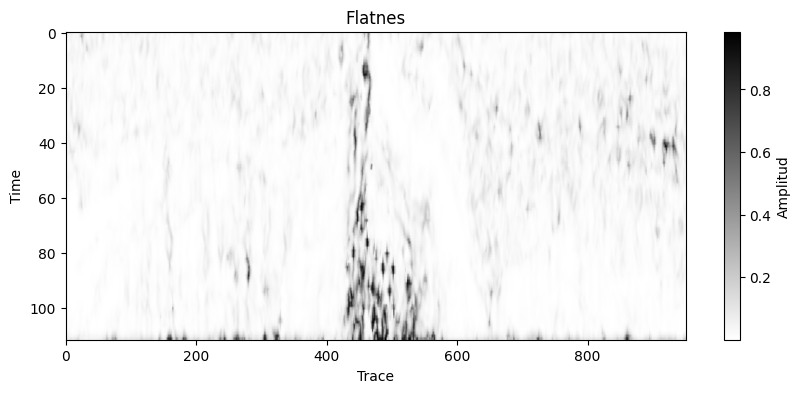

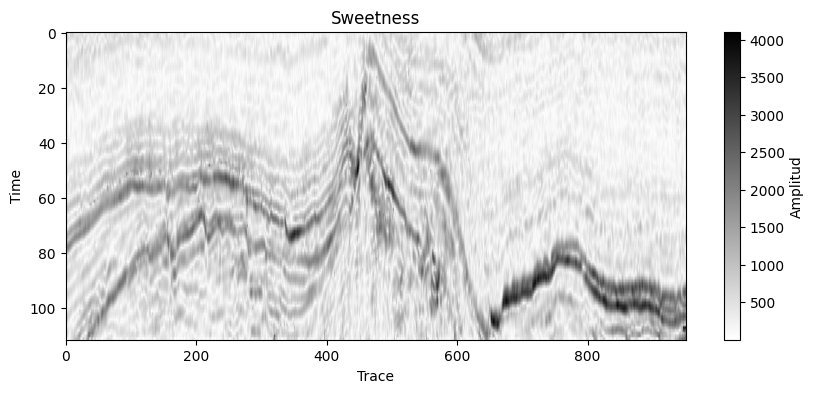

In [4]:
line = 1 #Line 442 corresponde to the line 1 of the cropped volume
top= 350
amplit = seismic2df('F3_entire.segy',line,'Amplitude',top)
refint = seismic2df('RefInt.segy',line,'ReflecInten',top)
chaos1 = seismic2df('Chaos.segy',line,'Chaos',top)
flatns = seismic2df('Flatnes.segy',line,'Flatnes',top)
sweetn = seismic2df('Sweet.segy',line,'Sweetness',top)

There five seimic line look ok, there are not missing traces, and all of them has information for the same time window.
Now,  I'm going to stack each of the attributee in a column and create a dataframe cotaining all these seismic attributes.

In [5]:
df_joined = amplit.join([refint, chaos1, flatns, sweetn ], how='outer')
df_joined.head()

Amplitude  ReflecInten     Chaos   Flatnes   Sweetness
1404.0 300    -1839.0     5.788000  0.639193  0.062609  704.818604
       301    -2672.0     6.710000  0.566212  0.063716  564.277100
       302    -2468.0     6.281778  0.486470  0.058842  564.643555
       303    -2164.0     6.171333  0.403466  0.048828  422.657227
       304     -622.0     5.273778  0.352177  0.040482  102.347809

Now, I'm going to import the well information. According to the documentation this well is located at the same position of the previous seismic images. The well contains information about lithology, and can be use at the final stage to interpret the results of the unsupervised classification.


In [6]:
well = pd.read_csv('LithologyW1.txt')
wellarray = np.array(well)
wellarray = wellarray[top+1:-1,1]
wellarray1 = pd.DataFrame(wellarray, columns=['Lithology'])

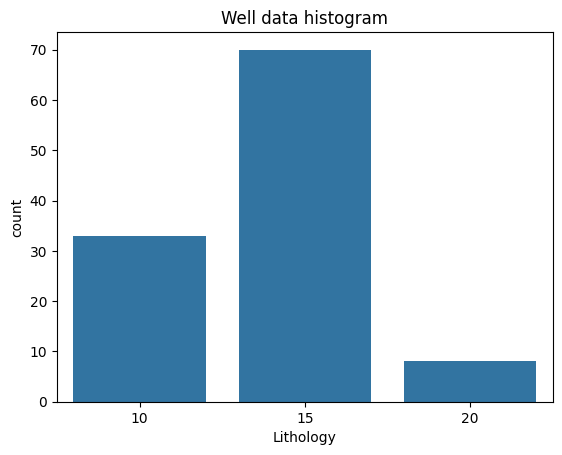

In [7]:
sns.countplot(x='Lithology', data=wellarray1)
plt.title('Well data histogram')
plt.show()

Based on the previous histogram, we have three lithologies for this well. According to the description in the documentation, code 10 is sandstone, 15 is silty sandstone and 20 is siltstone

In [10]:
sc = MinMaxScaler(feature_range = (0,1))
sc.fit(df_joined)
X=sc.transform(df_joined)

## Model creation
For this project, I'm going to use self organized maps and Kmeans.

A Self-Organizing Map (SOM) is an unsupervised neural network that projects high-dimensional data onto a typically two-dimensional grid while preserving the topological relationships between samples. Each cell in the grid has an associated weight vector; during training, input vectors “compete” to find the best-matching neuron and then adjust not only that neuron’s weights but also those of its neighbors. Over many iterations, similar inputs become mapped to nearby neurons, producing a spatially organized representation useful for clustering, visualization and dimensionality reduction.

In [54]:
som = MiniSom(x=20, y=20, input_len= X.shape[1], sigma= 1.0, learning_rate = 0.005)
som.random_weights_init(X)
som.train_random(data = X, num_iteration = 300)

win_map = som.win_map(X)
bmus = [som.winner(xi) for xi in X]

In the previous code I create the SOM and store the predicitons in the *bmus* variable. Next we can analyze the result of the model and observe the Matrix with the distances between nodes

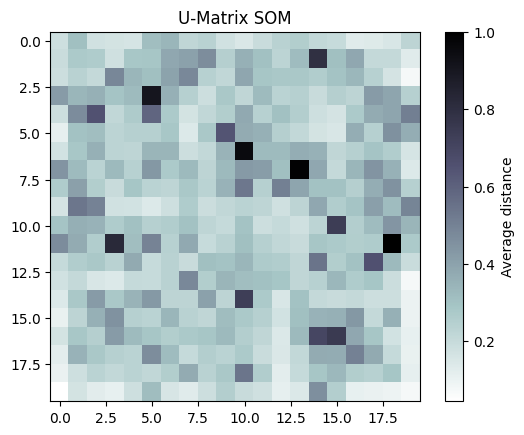

In [55]:
u_matrix = som.distance_map().T
plt.imshow(u_matrix, cmap='bone_r')
plt.colorbar(label='Average distance')
plt.title('U-Matrix SOM')
plt.show()

Next, I'm going to use Kmeans to generate clusters from the results of the self organized map. For Kmeans, first I'll use the elbow method to analize the beahavior of the number of clusters

In [56]:
weights = som.get_weights().reshape(-1, X.shape[1])

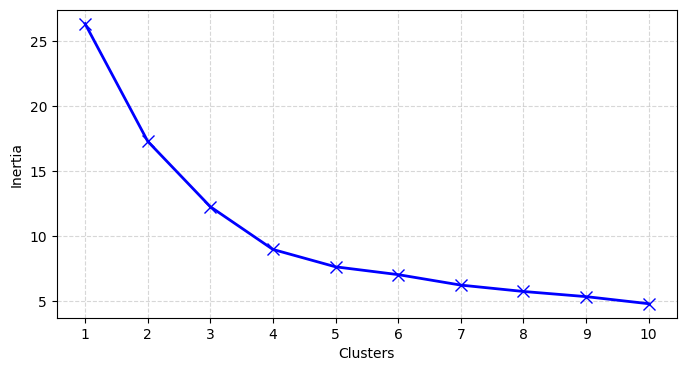

In [82]:
Ks = range(1, 11)
inertias = []

for k in Ks:
    km = KMeans(n_clusters=k, random_state=0)
    km.fit(weights)
    inertias.append(km.inertia_)

plt.figure(figsize=(8, 4))
plt.plot(Ks, inertias, 'bx-', linewidth=2, markersize=8)
plt.xlabel('Clusters')
plt.ylabel('Inertia')
plt.xticks(Ks)
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

Based on the plot, we can see a change at four clusters. However, because we only have three categories for lithology, I'll use three clusters. Now we can observe how each node was assigned to a different cluster

In [113]:
clusters = 3
kmeans = KMeans(n_clusters=clusters, random_state=0).fit(weights)
labels_map = kmeans.labels_.reshape(20,20)

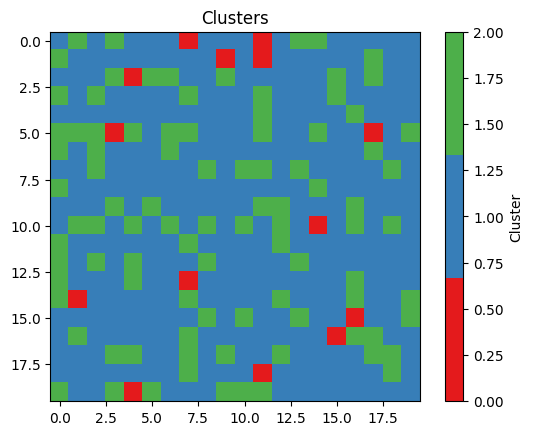

In [119]:
from matplotlib.colors import ListedColormap
base = plt.get_cmap('Set1')
new_colors = base.colors[:clusters]
cmap4 = ListedColormap(new_colors)
plt.imshow(labels_map, cmap=cmap4)
plt.colorbar(label='Cluster')
plt.title('Clusters')
plt.show()

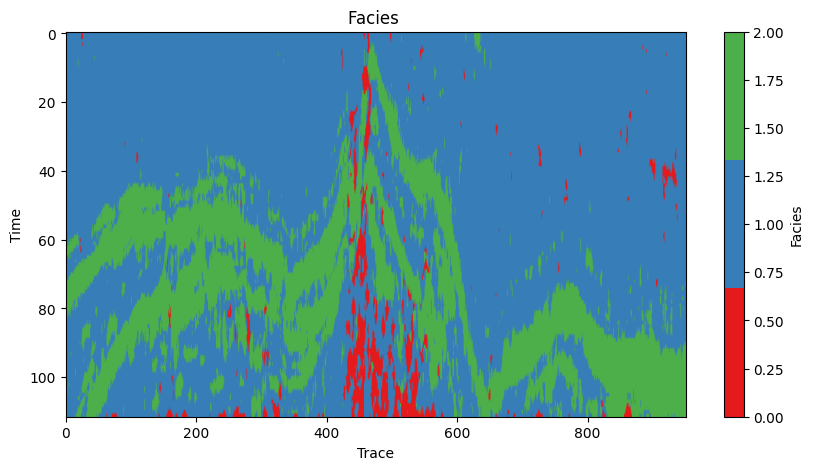

In [115]:
base = plt.get_cmap('Set1')
new_colors = base.colors[:clusters]
cmap4 = ListedColormap(new_colors)
plt.figure(figsize=(10, 5))
plt.imshow(arr2d.T, aspect='auto', cmap=cmap4)
plt.colorbar(label='Facies')
plt.xlabel('Trace')
plt.ylabel('Time')
plt.title(f'Facies ')
plt.show()

After, calculate the clusters, we can consider each of this as a seismic facies, the previous image is the result of the unsupervised facies classification. We can notice how the 3 values are clearly defined, with good lateral continuity and horizontal spearation, which is what we sohuld expect from a geological point of view.

The final step is try to look for any relation with the lithology from the well, for this step, I'm going to look the best match between seismic facies and lithology and calculate the accuracy considering that each facies is equivalen to an specific lithology

In [116]:
unique_categories = sorted(pd.Series(wellarray).unique())
label_mapping = {cat: idx for idx, cat in enumerate(unique_categories)}
labels_true = pd.Series(wellarray).map(label_mapping).values
cm = confusion_matrix(labels_true, extractfacies)
row_ind, col_ind = linear_sum_assignment(-cm)
topic_to_label = {col: row for row, col in zip(row_ind, col_ind)}
predicted_mapped = np.array([topic_to_label[label] for label in extractfacies])
acc = accuracy_score(labels_true, predicted_mapped)
print(f"Accuracy: {acc:.2f}")

Accuracy: 0.61


The result indicate and accuracy of 0.61, this result is acceptable, considering there are other factors that can be related to the seismic facies, like porosity of the rocks or water saturation. However, we don't have enough data to analyze in detail this other factors

## Hyperparameter tunning
I use a grid search to look for the best parameters, that minimize the error. In the parameters, I consider the number of nodes in X and Y, sigma, learning rate and number of iterations.

In [127]:
# Search space
param_grid = {
    'x':      [10, 20],
    'y':      [10, 20],
    'sigma':  [1.0, 2.0],
    'learning_rate': [0.005, 0.01, 0.1, 0.5],
    'num_iteration': [100, 300, 500, 1000]
}

best_params, best_qe = None, np.inf
for p in ParameterGrid(param_grid):
    som = MiniSom(p['x'], p['y'],
                  input_len= X.shape[1],
                  sigma=p['sigma'],
                  learning_rate=p['learning_rate'],
                  neighborhood_function='gaussian',
                  random_seed=42)
    #som.pca_weights_init(X)
    som.random_weights_init(X)
    som.train_random(data = X, num_iteration = p['num_iteration'])
    qe = som.quantization_error(X)
    te = som.topographic_error(X)
    if qe < best_qe:
        best_qe, best_params = qe, p

print("Best parameters:", best_params)
print("Quantization Error:", best_qe)

/usr/local/lib/python3.11/dist-packages/minisom.py:631: RuntimeWarning: invalid value encountered in sqrt
  return sqrt(-2 * cross_term + input_data_sq + weights_flat_sq.T)


Best parameters: {'learning_rate': 0.1, 'num_iteration': 100, 'sigma': 1.0, 'x': 20, 'y': 20}
Quantization Error: 0.048467950846694856


The results indicate the Best parameters are:
*   Learning_rate: 0.1
*   Num_iteration: 100
*   Sigma: 1.0
*   X: 20
*   Y: 20

Quantization Error: 0.048

## Conclusions
* Unsupervised machine learning was succesfully applied to the geoscience problem.
* Using a combination of self orgainzed maps and Kmeans, it was possible to classify seismic facies, and we can notice there was a good correlation between this classification and the lithology.
* Future work could consider include different seismic attributes in the model or used some king of supervised aproach using the information from wells
